# RI

## RI grids

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
data = xr.open_dataset("../Diurnal-TC/ibtracs_2021-11-18/IBTrACS.ALL.v04r00.nc")
p1=1980
p2=2020
t =data["time"]
year=t["time.year"].values[:,0]
v =data["usa_wind"][:,::2]
lon = data['usa_lon'][:,::2]
lat = data["usa_lat"][:,::2]
mm=t["time.month"].values[:,0]

year_p1_p2 = np.where((year >= p1) & (p2 >= year))
year_p1_p2 = np.squeeze(year_p1_p2)
v = v[year_p1_p2, :].values
lat = lat[year_p1_p2, :].values
lon = lon[year_p1_p2, :].values
lon[lon<0]=lon[lon<0]+360
mm = mm[year_p1_p2]
year=year[year_p1_p2]
v_24n= np.ones((np.size(v, 0),np.size(v, 1))) * np.nan
v_24n[:,:176]=v[:,4:180]-v[:,:176] # 24h intensity changes

In [60]:
ri_density= np.zeros((41,41,180)) #  #1980-2020ri density,2*2grids, 
for i in range(41):
    p1=i+1980
    year_ind=np.where(year==p1)
    v_year=v[year_ind,:]
    v_year = np.squeeze(v_year)
    lon_year=lon[year_ind,:]
    lon_year = np.squeeze(lon_year)
    lat_year=lat[year_ind,:]
    lat_year = np.squeeze(lat_year)
    m_year = mm[year_ind]
    v_24n_year=v_24n[year_ind]
    
    ym_ind = np.where((m_year>=4) & (m_year<=6))
    if np.size(ym_ind)==0:
        continue

    v_ym=v_year[ym_ind,:]
    v_ym = np.squeeze(v_ym)
    v_ym = np.reshape(v_ym,(np.size(ym_ind),180))
    lon_ym=lon_year[ym_ind,:]
    lon_ym = np.squeeze(lon_ym)
    lat_ym=lat_year[ym_ind,:]
    lat_ym = np.squeeze(lat_ym)
    lat_ym = np.reshape(lat_ym,(np.size(ym_ind),180))
    lon_ym = np.reshape(lon_ym,(np.size(ym_ind),180))
    v_24n_ym=v_24n_year[ym_ind,:]
    v_24n_ym = np.squeeze(v_24n_ym)
    v_24n_ym = np.reshape(v_24n_ym,(np.size(ym_ind),180))
    
    
    xGrid = np.arange(0,360,2)
    yGrid = np.arange(-40,41,2)
    ri_d= np.zeros((41,180))
    for m in range(np.size(v_ym,0)):
        for n in range(np.size(v_ym,1)-4):
            if v_24n_ym[m,n]>=20:
                X = np.squeeze(np.where(lon_ym[m,n]<=xGrid))
                Y = np.squeeze(np.where(lat_ym[m,n]<=yGrid))
                if np.size(Y)>1:
                    y=Y[0]
                if np.size(X)>1:
                    x=X[0]
                ri_d[y,x] = ri_d[y,x]+1
        ri_density[i,:,:]=ri_d

## smooth

In [61]:
def spatial_9_points_smooth(field_2d):
    field_smooth= np.zeros((np.size(field_2d,0),np.size(field_2d,1)))
    for i in range(np.size(field_2d,0)):
        for j in range(np.size(field_2d,1)):
            if i==0 or j==0 or i== np.size(field_2d,0)-1 or j== np.size(field_2d,1)-1:
                field_smooth[i,j]=field_2d[i,j]
            else:
                field_smooth[i,j] = (field_2d[i-1,j]+field_2d[i,j]+field_2d[i+1,j]+field_2d[i-1,j-1]+field_2d[i,j-1]+field_2d[i+1,j-1]+field_2d[i-1,j+1]+field_2d[i,j+1]+field_2d[i+1,j+1])/9  
    return(field_smooth)
    
def spatial_9_points_smooth_3(field_3d):
    field_s = np.zeros((np.size(field_3d,0),np.size(field_3d,1),np.size(field_3d,2)))
    for i in range (np.size(field_3d,0)):
        field_s[i,:,:] = spatial_9_points_smooth(np.squeeze(field_3d[i,:,:]))
    return (field_s)
                
                
ri_density = spatial_9_points_smooth_3(ri_density)

In [62]:
ri_density = xr.DataArray(ri_density,coords=[np.arange(1980,2021),yGrid,xGrid],dims=["time",'lat', 'lon'])

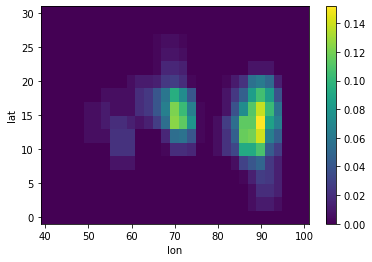

In [63]:
ri_density.sel(lat=slice(0,30),lon=slice(40,100)).mean(dim="time").plot()

In [64]:
ri_NI=ri_density.sel(lat=slice(0,30),lon=slice(40,100))
ri_NI = xr.DataArray((ri_NI.values-np.mean(ri_NI.values,axis=0)),
                coords=[ri_NI["time"],ri_NI["lat"],ri_NI["lon"]],
                    dims=['time', 'lat',"lon"])

# SST

In [65]:
sst = xr.open_dataset("d:/NNRP_NEW/2022/sst.mnmean.nc")
sst=sst["sst"].transpose(*['time', 'lat', 'lon'])
sst_m=sst[np.squeeze(np.where((sst.time["time.year"]>=1980) & (2020>=sst.time["time.year"])))]
sst_m=sst_m[(sst_m.time["time.month"]>=4) & (6>=sst_m.time["time.month"])]
sst_m=sst_m.sel(lat=slice(30,0),lon=slice(40,100)).groupby('time.year').mean()
sst_m = xr.DataArray((sst_m.values-np.mean(sst_m.values,axis=0)),
                coords=[sst_m["year"],sst_m["lat"],sst_m["lon"]],
                    dims=['time', 'lat',"lon"])

# SVD

In [57]:
import xarray as xr
from xMCA import xMCA
import netCDF4 as nc
from pylab import *
import matplotlib.pyplot as plt
import cmaps
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

## postmonsoon

<xarray.DataArray 'frac' (n: 3)>
array([0.76933884, 0.09563626, 0.06002863])
Coordinates:
  * n        (n) int32 0 1 2
Attributes:
    long_name:  Fractions explained of the covariance matrix between left and...


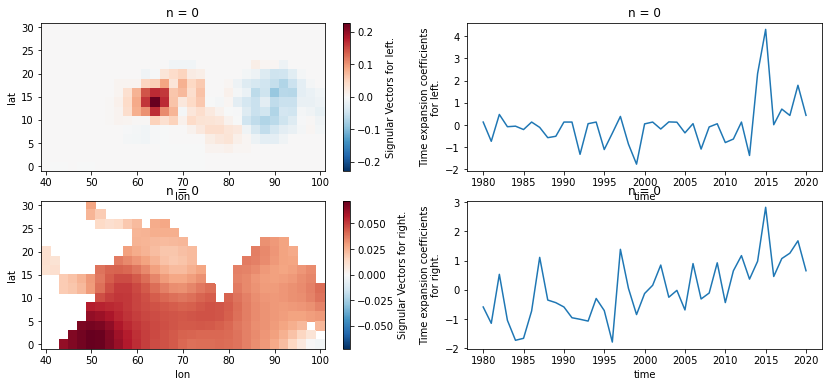

In [58]:
RI_SST = xMCA(ri_NI, sst_m)
RI_SST.solver()
lp, rp = RI_SST.patterns(n=3)  #  lp :RI，rp:SST,
le, re = RI_SST.expansionCoefs(n=3)  # PCs
frac = RI_SST.covFracs(n=3)  # Fractions explained of the covariance matrix
print(frac)
fig, (ax1,ax2) = plt.subplots(2, 2, figsize=(14, 6))
(-lp[0]).plot(ax=ax1[0])
(-le[0]).plot(ax=ax1[1])

(-rp[0]).plot(ax=ax2[0])
(-re[0]).plot(ax=ax2[1])

In [59]:
RI_SST_SVD_postmonsoon= xr.Dataset({'lp': lp,"rp":rp,"le":le,"re":re,"frac":frac})
RI_SST_SVD_postmonsoon.to_netcdf("RI_SST_SVD_postmonsoon.nc")

## premonsoon

<xarray.DataArray 'frac' (n: 3)>
array([0.86158455, 0.04452355, 0.04127186])
Coordinates:
  * n        (n) int32 0 1 2
Attributes:
    long_name:  Fractions explained of the covariance matrix between left and...


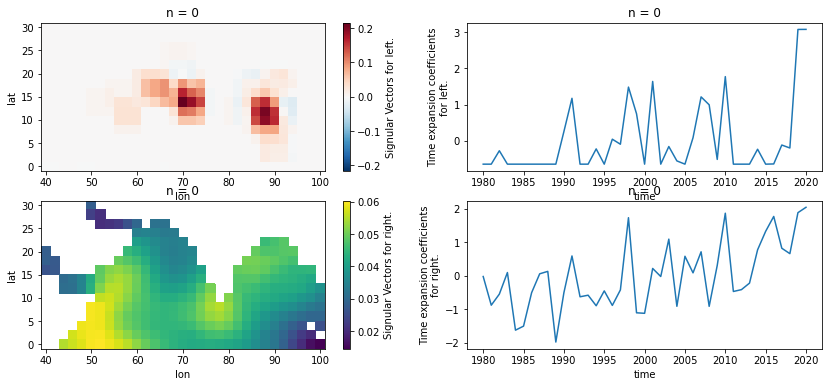

In [66]:
RI_SST = xMCA(ri_NI, sst_m)
RI_SST.solver()
lp, rp = RI_SST.patterns(n=3)  #  lp :RI，rp:SST,
le, re = RI_SST.expansionCoefs(n=3)  # PCs
frac = RI_SST.covFracs(n=3)  # Fractions explained of the covariance matrix
print(frac)
fig, (ax1,ax2) = plt.subplots(2, 2, figsize=(14, 6))
(-lp[0]).plot(ax=ax1[0])
(-le[0]).plot(ax=ax1[1])

(-rp[0]).plot(ax=ax2[0])
(-re[0]).plot(ax=ax2[1])

In [67]:
RI_SST_SVD_premonsoon= xr.Dataset({'lp': lp,"rp":rp,"le":le,"re":re,"frac":frac})
RI_SST_SVD_premonsoon.to_netcdf("RI_SST_SVD_premonsoon.nc")